# Intelligent Systems - Assignment 1

- Author: Tim Hrovat
- Student no.: 63230112
- Date: 30. 11. 2025

## Task 1: Shortest Path Between Two Nodes

### Setup and imports

This is a list of required libraries to run and test my solution. I also defined a random seed for result reporoducability.


In [25]:
# import sys
# !{sys.executable} -m pip install pygad networkx

import pygad
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from typing import List, Tuple

random.seed(42)
np.random.seed(42)

### Graph representation and input

First, I defined a helper class named GraphManager to help me read the graphs from .txt files and I also added a dijkstra method to help me test my implementation of the path finding algorithm.

In [26]:
class GraphManager:
    def __init__(self):
        self.graph = None
        self.num_nodes = 0

    def read(self, filename: str) -> nx.DiGraph:
        self.graph = nx.DiGraph()

        with open(filename, 'r') as file:
            lines = file.readlines()
            self.num_nodes = int(lines[0].strip())

            for i in range(1, self.num_nodes + 1):
                self.graph.add_node(i)

            for line in lines[1:]:
                if line.strip():
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        node_a, node_b, weight = int(parts[0]), int(
                            parts[1]), float(parts[2])
                        self.graph.add_edge(node_a, node_b, weight=weight)

        return self.graph
        
    def display(self, title: str = "Graph Visualization",
            figsize: Tuple[int, int] = (12, 8),
            show_weights: bool = True,
            node_color: str = 'lightblue',
            edge_color: str = 'gray') -> None:
        plt.figure(figsize=figsize)

        pos = nx.spring_layout(self.graph, seed=42)

        nx.draw_networkx_nodes(self.graph, pos, node_color=node_color,
                              node_size=500, alpha=0.9)
        nx.draw_networkx_edges(self.graph, pos, edge_color=edge_color,
                              arrows=True, arrowsize=20, alpha=0.7)
        nx.draw_networkx_labels(self.graph, pos, font_size=12, font_weight='bold')

        if show_weights:
            edge_labels = nx.get_edge_attributes(self.graph, 'weight')
            nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, font_size=10)

        plt.title(title, fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def dijkstra(self, start: int, end: int) -> Tuple[List[int], float]:
        try:
            path = nx.shortest_path(self.graph, start, end, weight='weight')
            distance = nx.shortest_path_length(
                self.graph, start, end, weight='weight')
            return path, distance
        except nx.NetworkXNoPath:
            return [], float('inf')

### Implementation

I encapsulated my solution to the 1st task inside a Task1GA class. The implementation details are described via inline comments inside the code section.

In [27]:
class Task1GA:
    def __init__(self, graph_manager: GraphManager, start_node: int, end_node: int):
        self.graph_manager = graph_manager
        self.graph = graph_manager.graph
        self.start_node = start_node
        self.end_node = end_node
        self.nodes = list(self.graph.nodes())
        self.max_path_length = min(len(self.nodes) * 2, 20)
        self.gene_space = self.nodes + [-1]  # -1 for unused positions
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.fitness_history = []

    def decode_chromosome(self, chromosome: List[int]) -> List[int]:
        # Remove unused genes
        path = [gene for gene in chromosome if gene != -1]

        # path should start with required start_node
        if not path or path[0] != self.start_node:
            path = [self.start_node] + [node for node in path if node != self.start_node]

        # path should end with required end_node
        if not path or path[-1] != self.end_node:
            if self.end_node in path:
                path = [node for node in path if node != self.end_node] + [self.end_node]
            else:
                path.append(self.end_node)

        return path

    def calculate_path_distance(self, path: List[int]) -> float:
        if len(path) < 2:
            return float('inf')

        total_distance = 0
        # Sum edge weights
        for i in range(len(path) - 1):
            if self.graph.has_edge(path[i], path[i + 1]):
                total_distance += self.graph[path[i]][path[i + 1]]['weight']
            else:
                return float('inf')

        return total_distance

    def fitness_function(self, ga_instance, solution, solution_idx):
        path = self.decode_chromosome(solution)

        # Big penalty if path invalid
        if len(path) < 2 or path[0] != self.start_node or path[-1] != self.end_node:
            return -1000

        distance = self.calculate_path_distance(path)
        # Big penalty for disconnected paths
        if distance == float('inf'):
            return -1000

        # Small penalty for long paths
        length_penalty = len(path) * 0.1

        fitness = 1000 / (distance + length_penalty + 1)

        # Track fitness
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = path.copy()

        return fitness

    def generate_initial_population(self, population_size: int) -> List[List[int]]:
        population = []

        for _ in range(population_size):
            # start node
            chromosome = [self.start_node]

            # random intermediate nodes
            num_intermediate = random.randint(0, self.max_path_length - 2)
            for _ in range(num_intermediate):
                chromosome.append(random.choice(self.nodes))

            # end node
            chromosome.append(self.end_node)

            # -1 padding
            while len(chromosome) < self.max_path_length:
                chromosome.append(-1)

            chromosome = chromosome[:self.max_path_length]
            population.append(chromosome)

        return population

    def mutation(self, offspring, ga_instance):
        # Randomly mutate offspring based on mutation probability
        for chromosome_idx in range(offspring.shape[0]):
            if random.random() >= ga_instance.mutation_probability:
                continue

            mutation_type = random.choice(['replace', 'insert', 'remove'])

            if mutation_type == 'replace':
                # Replace a random gene with another valid gene
                gene_idx = random.randint(1, len(offspring[chromosome_idx]) - 2)
                offspring[chromosome_idx][gene_idx] = random.choice(self.gene_space)

            elif mutation_type == 'insert':
                # Insert a node where a -1 exists
                gene_idx = random.randint(1, len(offspring[chromosome_idx]) - 1)
                if offspring[chromosome_idx][gene_idx] == -1:
                    offspring[chromosome_idx][gene_idx] = random.choice(self.nodes)

            elif mutation_type == 'remove':
                # Replace intermediate gene with -1 (but keep start/end fixed)
                gene_idx = random.randint(1, len(offspring[chromosome_idx]) - 2)
                if offspring[chromosome_idx][gene_idx] not in [self.start_node, self.end_node]:
                    offspring[chromosome_idx][gene_idx] = -1

        return offspring

    def crossover(self, parents, offspring_size, ga_instance):
        offspring = []

        for _ in range(offspring_size[0]):
            # Choose two random parents
            parent1_idx = random.randint(0, parents.shape[0] - 1)
            parent2_idx = random.randint(0, parents.shape[0] - 1)

            parent1 = parents[parent1_idx]
            parent2 = parents[parent2_idx]

            # Single-point crossover
            crossover_point = random.randint(1, len(parent1) - 1)
            child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])

            child[0] = self.start_node
            end_pos = len(child) - 1

            while end_pos > 0 and child[end_pos] == -1:
                end_pos -= 1
            if end_pos < len(child) - 1:
                child[end_pos + 1] = self.end_node
            else:
                child[end_pos] = self.end_node

            offspring.append(child)

        return np.array(offspring)

    def on_generation(self, ga_instance):
        # Store best fitness of this generation
        best_fitness = ga_instance.best_solution()[1]
        self.fitness_history.append(best_fitness)
        
    def run(self, population_size: int = 50, num_generations: int = 100,
            mutation_probability: float = 0.1, num_parents_mating: int = 10):
        print(f"Running GA: {self.start_node} → {self.end_node}")

        initial_population = self.generate_initial_population(population_size)

        start_time = time.time()

        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=self.fitness_function,
            initial_population=initial_population,
            gene_space=self.gene_space,
            mutation_probability=mutation_probability,
            crossover_type=self.crossover,
            mutation_type=self.mutation,
            parent_selection_type='rws',
            on_generation=self.on_generation,
            suppress_warnings=True
        )

        ga_instance.run()
        execution_time = time.time() - start_time

        solution, solution_fitness, _ = ga_instance.best_solution()
        best_path = self.decode_chromosome(solution)
        best_distance = self.calculate_path_distance(best_path)

        dijkstra_path, dijkstra_distance = self.graph_manager.dijkstra(
            self.start_node, self.end_node)

        print(f"\nResults:")
        print(f"GA Path: {best_path}, Distance: {best_distance}")
        print(f"Dijkstra Path: {dijkstra_path}, Distance: {dijkstra_distance}")
        print(f"Execution Time: {execution_time:.2f}s")

        return {
            'best_path': best_path,
            'best_distance': best_distance,
            'dijkstra_path': dijkstra_path,
            'dijkstra_distance': dijkstra_distance,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time
        }

### Implementation test

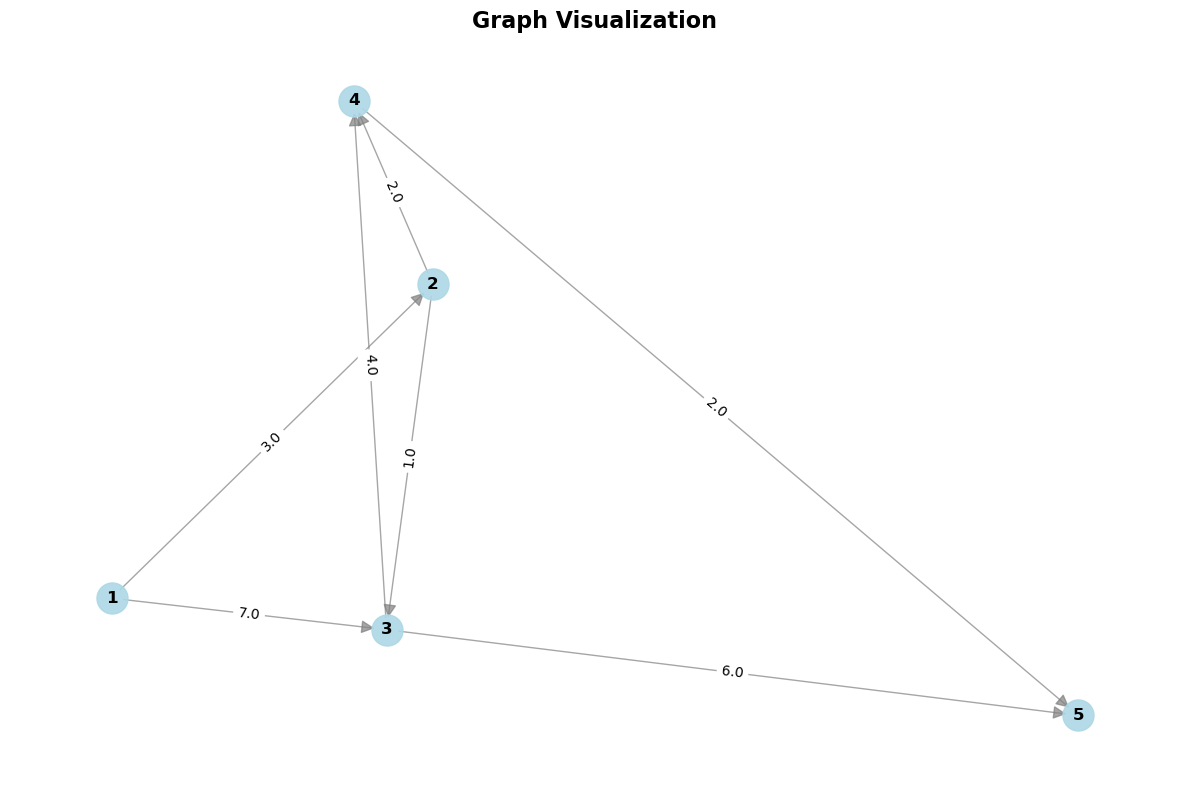

Running GA: 1 → 5

Results:
GA Path: [np.float64(1.0), np.float64(2.0), np.float64(3.0), 5], Distance: 10.0
Dijkstra Path: [1, 2, 4, 5], Distance: 7.0
Execution Time: 0.02s


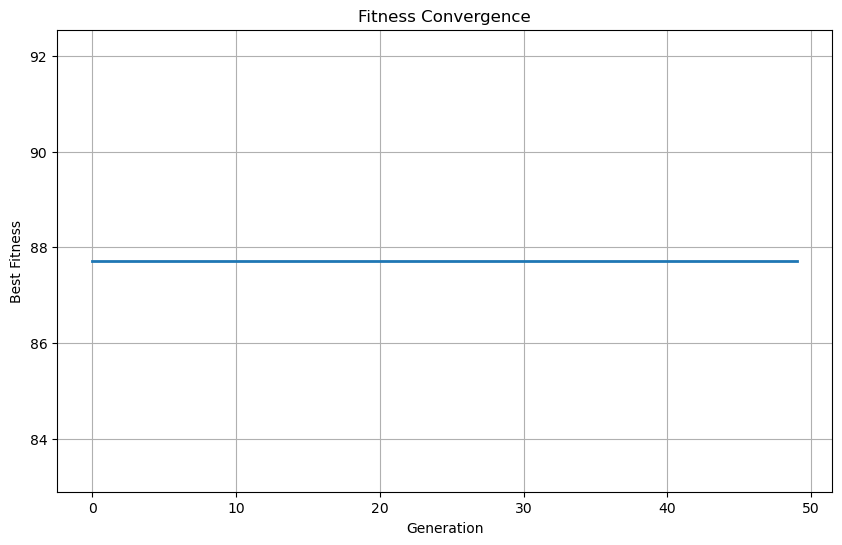

In [28]:
def plot_fitness_convergence(result):
    if not result or 'fitness_history' not in result:
        return

    plt.figure(figsize=(10, 6))
    plt.plot(result['fitness_history'], linewidth=2)
    plt.title('Fitness Convergence')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.show()


def task_1_test():
    # Create graph manager and load graph
    graph_manager = GraphManager()
    graph_manager.read('graphs/medium_graph.txt')

    # Display the graph
    graph_manager.display()

    # Create GA solver with graph manager
    ga_solver = Task1GA(graph_manager, start_node=1, end_node=5)

    # Run the genetic algorithm
    result = ga_solver.run(
        population_size=30,
        num_generations=50,
        mutation_probability=0.2
    )

    if result:
        plot_fitness_convergence(result)

task_1_test()